In [27]:
!pip install optuna

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.model_selection import train_test_split
import optuna

In [29]:
# Cargar el dataset
data = pd.read_csv('Temp_Asu20092021.csv')

[I 2024-11-07 12:25:12,230] A new study created in memory with name: no-name-200f76f5-e847-45b3-b033-5b3fb580bd4b
<ipython-input-30-6eeb73b93b4c>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
[I 2024-11-07 12:25:12,274] Trial 0 finished with value: 3.606559524744966 and parameters: {'alpha': 2.937585345919934}. Best is trial 0 with value: 3.606559524744966.
<ipython-input-30-6eeb73b93b4c>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
[I 2024-11-07 12:25:12,307] Trial 1 finished with value: 3.605234758159191 and parameters: {'alpha': 7.440797193323293}. Bes

Mejor alpha: 9.957898241773067
MSE en el conjunto de validación: 3.6046254790954593
RMSE en el conjunto de validación: 1.8985851255857502
MAE en el conjunto de validación: 1.3678387140865476
R² en el conjunto de validación: 0.9354851410660162
Error máximo en el conjunto de validación: 16.768700802296706


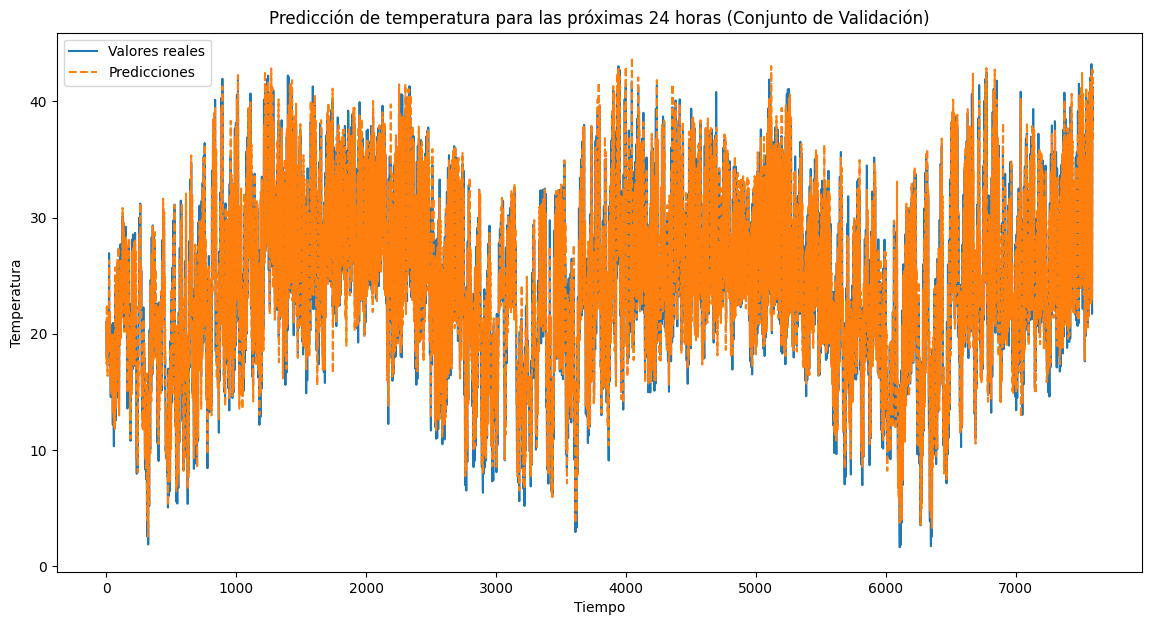

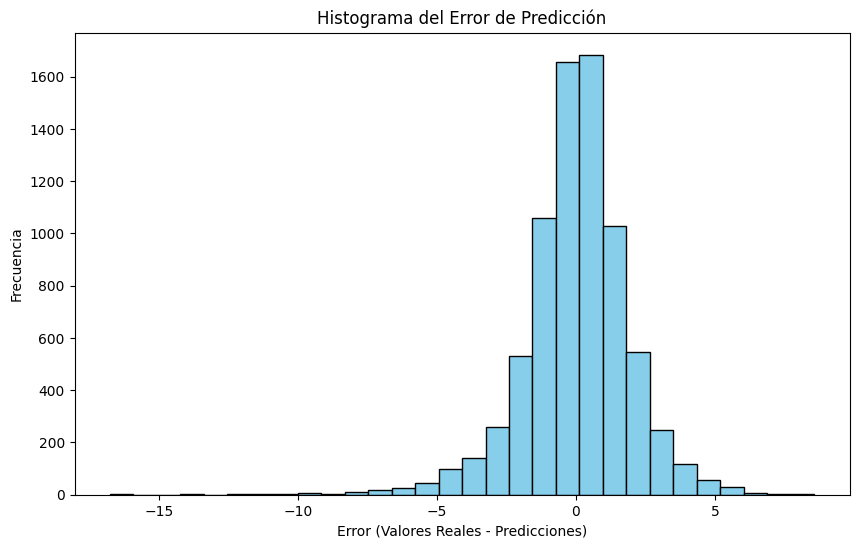


Evaluación en el conjunto de prueba final:
MSE: 3.6046254790954593
RMSE: 1.8985851255857502
MAE: 1.3678387140865476
R²: 0.9354851410660162
Error máximo: 16.768700802296706


In [30]:
# Convertir la columna 'Fecha' a tipo datetime y establecerla como índice
data['Fecha'] = pd.to_datetime(data['Fecha'])
data = data.set_index('Fecha')
data = data.sort_index()

# Función para crear una serie temporal supervisada
def create_supervised(data, n_lags=24):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Preparar datos de temperatura para el modelo
temperature_data = data['Temperatura'].values
X, y = create_supervised(temperature_data, n_lags=24)

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función objetivo para Optuna
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Mejor modelo encontrado
best_alpha = study.best_params['alpha']
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Calcular el error cuadrático medio en el conjunto de validación
mse_val = mean_squared_error(y_test, y_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test, y_pred)
r2_val = r2_score(y_test, y_pred)
max_err_val = max_error(y_test, y_pred)

print(f"Mejor alpha: {best_alpha}")
print(f"MSE en el conjunto de validación: {mse_val}")
print(f"RMSE en el conjunto de validación: {rmse_val}")
print(f"MAE en el conjunto de validación: {mae_val}")
print(f"R² en el conjunto de validación: {r2_val}")
print(f"Error máximo en el conjunto de validación: {max_err_val}")

# Graficar los resultados en el conjunto de validación
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores reales')
plt.plot(y_pred, label='Predicciones', linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura')
plt.legend()
plt.title('Predicción de temperatura para las próximas 24 horas (Conjunto de Validación)')
plt.show()

# Calcular los errores residuales y graficar el histograma de los errores
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Error (Valores Reales - Predicciones)')
plt.ylabel('Frecuencia')
plt.title('Histograma del Error de Predicción')
plt.show()

# Evaluación del modelo en un conjunto de prueba independiente (últimos 20% del conjunto original)
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_final_scaled = scaler.transform(X_test_final)

# Entrenar el modelo final con el mejor alpha
model = Ridge(alpha=best_alpha)
model.fit(X_train_full_scaled, y_train_full)
y_pred_final = model.predict(X_test_final_scaled)

# Calcular métricas de evaluación en el conjunto de prueba final
mse_test = mean_squared_error(y_test_final, y_pred_final)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_final, y_pred_final)
r2_test = r2_score(y_test_final, y_pred_final)
max_err_test = max_error(y_test_final, y_pred_final)

print(f"\nEvaluación en el conjunto de prueba final:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")
print(f"Error máximo: {max_err_test}")